In [1]:
import itertools
import pickle
import warnings
warnings.simplefilter('ignore')
import datetime as dt

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
# plt.rcParams['font.family'] = 'Noto Sans CJK JP'
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from utils.helper import fix_seed, seed_worker, validate, multistep_validate
from dataset import STDataset
from trainer import Trainer
from logger import Logger
import config

In [2]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=2)

## データセットの定義

In [3]:
dt_table = pd.read_pickle(f'datasets_1h/tables/datetime_table.pkl')
sec_table = pd.read_pickle(f'datasets_1h/tables/section_table.pkl')

X_tr = torch.load(f'{config.DATASET_DIR}_1h/features_train_norm.pkl')
X_va = torch.load(f'{config.DATASET_DIR}_1h/features_test_norm.pkl')
y_tr = torch.load(f'{config.DATASET_DIR}_1h/labels_train.pkl')
y_va = torch.load(f'{config.DATASET_DIR}_1h/labels_test.pkl')

print(dt_table.shape, sec_table.shape)
print(X_tr.shape, X_va.shape)
print(y_tr.shape, y_va.shape)

(288, 1) (63, 4)
torch.Size([5, 7992, 63]) torch.Size([5, 2208, 63])
torch.Size([1, 7992, 63]) torch.Size([1, 2208, 63])


In [5]:
def zeroing_feature(tensor, feature_nums):
    new = tensor.clone()
    for f in feature_nums:
        new[f] = 0
    return new

In [6]:
X_tr_wo_search = zeroing_feature(X_tr, [2, 3])
X_tr_wo_context = zeroing_feature(X_tr, [0, 1])
X_tr_wo_both = zeroing_feature(X_tr, [0, 1, 2, 3])

X_va_wo_search = zeroing_feature(X_va, [2, 3])
X_va_wo_context = zeroing_feature(X_va, [0, 1])
X_va_wo_both = zeroing_feature(X_va, [0, 1, 2, 3])

In [4]:
time_step = 7 * 24
space_window = (-2, 2)

dataset_train = STDataset(X_tr, y_tr, 
                          time_step=time_step, 
                          space_window=space_window)

dataset_valid = STDataset(X_va, y_va, 
                          time_step=time_step, 
                          space_window=space_window)

## Networkの定義

In [5]:
TRAFFIC_CONV = 64
TRAFFIC_HIDDEN = 128
TRAFFIC_LSTM_LAYERS = 4
TRAFFIC_KERNEL = (7,5)

SEARCH_CONV = 64
SEARCH_HIDDEN = 128
SEARCH_LSTM_LAYERS = 4
SEARCH_KERNEL = (7,5)

UNSPEC_SEARCH_HIDDEN = 64
UNSPEC_SEARCH_KERNEL = 5

DATETIME_EMB = 32
ROAD_EMB = 16

FC_EMB = 32

PREDICTION_HORIZON = 24

### LSTM only EncDec

In [6]:
class LSTMEncoder(nn.Module):
    def __init__(self, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        self.lstm = nn.LSTM(1, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS, 
                            bidirectional=bidirectional, dropout=lstm_dropout, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        x = x[..., [S // 2]]
        # N x T x 1 -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(x)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
        
        return outs, (h, c)
    

class LSTMDecoder(nn.Module):
    def __init__(self, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, 
                            dropout=lstm_dropout, batch_first=True)

        self.fc1 = nn.Linear(self.hid_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMOnlyEncoderDecoder(nn.Module):
    def __init__(self, lstm_dropout=0, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.encoder = LSTMEncoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        self.decoder = LSTMDecoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, start_value)
        return generated

### LSTM + CNN EncDec

In [7]:
class CNNLSTMEncoder(nn.Module):
    def __init__(self, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, TRAFFIC_CONV, TRAFFIC_KERNEL, 
                              padding=(TRAFFIC_KERNEL[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(TRAFFIC_CONV, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS,
                            dropout=lstm_dropout, bidirectional=bidirectional, batch_first=True)
    
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = h.shape
            h = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = h.transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
        
        return outs, (h, c)
    

class CNNLSTMEncoderDecoder(LSTMOnlyEncoderDecoder):
    def __init__(self, lstm_dropout=0, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.encoder = CNNLSTMEncoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        self.decoder = LSTMDecoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)

### LSTM + Embedding EncDec

In [8]:
class LSTMEmbeddingDecoder(nn.Module):
    def __init__(self, lstm_dropout, embedding_dropout=0.4, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.embedding_dropout = embedding_dropout
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=embedding_dropout)
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, 
                            dropout=lstm_dropout, batch_first=True)
        self.fc1 = nn.Linear(self.hid_dim + DATETIME_EMB + ROAD_EMB, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)

    def forward(self, x, state, dt, rd):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        outs = torch.cat([
            dt_emb, 
            rd_emb.repeat(1, P, 1), 
            outs
        ], dim=-1)
        
        outs = F.relu(self.fc1(outs))
        outs = self.fc2(outs)

        return outs, state
    
    def generate(self, trf_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.forward(out, state, dt[:, [i]], rd)
                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated
    

class LSTMEmbeddingEncoderDecoder(nn.Module):
    def __init__(self, lstm_dropout=0, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.encoder = LSTMEncoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        self.decoder = LSTMEmbeddingDecoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)
        outs, _ = self.decoder(decoder_xs, state_trf, dt, rd)
        outs = outs[..., 0]
        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        outs_trf, state_trf = self.encoder(trf)    
        generated = self.decoder.generate(state_trf, dt, rd, start_value)
        return generated

### T-ED

In [124]:
class T_TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        
        self.lstm = nn.LSTM(1, lstm_dim, lstm_layers, 
                            dropout=lstm_dropout, bidirectional=bidirectional, batch_first=True)
        
    def forward(self, x):
        N, T, S = x.shape
        
        x = x[..., [S // 2]]
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(x)
        
        return outs, (h, c)

    
class T_SearchUnspecEncoder(nn.Module):
    def __init__(self, p_dropout):
        super().__init__()
        
        self.p_dropout = p_dropout
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, x):
        N, T, S = x.shape
        
        x = x[..., [S // 2]]
        out = self.dropout(x)
        
        return out

    
class T_Encoder(nn.Module):
    def __init__(
        self, lstm_dropout, unspec_search_dropout=0.4, include_search=True, bidirectional=True
    ):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.unspec_search_dropout = unspec_search_dropout
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        self.traffic_encoder = T_TrafficSearchEncoder(
            TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS,
            lstm_dropout=lstm_dropout, bidirectional=bidirectional
        )
        
        if include_search:
            self.search_encoder = T_TrafficSearchEncoder(
                SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS,
                lstm_dropout=lstm_dropout, bidirectional=bidirectional
            )
            self.unspec_search_encoder = T_SearchUnspecEncoder(p_dropout=unspec_search_dropout)
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = state_trf[0].shape
            h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            state_trf = (h, c)
        
        if self.include_search:
            # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
            outs_sr, state_sr = self.search_encoder(x_sr)
            # N x 1 x S -> N x 1 x H_u
            out_un_sr = self.unspec_search_encoder(x_un_sr)
            return (outs_trf, state_trf), outs_sr, out_un_sr
        return outs_trf, state_trf

In [125]:
class T_EncoderDecoder(nn.Module):
    def __init__(self, lstm_dropout=0, include_search=True, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.include_search = include_search
        
        self.encoder = T_Encoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        self.decoder = Decoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
            
        outs = self.decoder(decoder_xs, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
        
        generated = self.decoder.generate(state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated

### STE-ED-S (ST-ED, STE-ED, ST-ED-S)

In [9]:
class TrafficSearchEncoder(nn.Module):
    def __init__(self, conv_dim, kernel, lstm_dim, lstm_layers, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.bidirectional = bidirectional
        
        self.conv = nn.Conv2d(1, conv_dim, kernel, 
                              padding=(kernel[0]//2, 0), padding_mode='replicate')
        self.lstm = nn.LSTM(conv_dim, lstm_dim, lstm_layers, 
                            dropout=lstm_dropout, bidirectional=bidirectional, batch_first=True)
        
    def forward(self, x):
        N, T, S = x.shape
        
        out = F.relu(self.conv(x.unsqueeze(1)))
        # N x C x T -> N x T x C
        out = out[..., 0].permute(0, 2, 1)
        # N x T x C -> N x T x H, (L x N x H, L x N x H)
        outs, (h, c) = self.lstm(out)
        
        return outs, (h, c)

    
class SearchUnspecEncoder(nn.Module):
    def __init__(self, p_dropout):
        super().__init__()
        
        self.p_dropout = p_dropout
        
        self.conv = nn.Conv1d(1, UNSPEC_SEARCH_HIDDEN, UNSPEC_SEARCH_KERNEL, padding_mode='replicate')
        # self.dropout = nn.Dropout(p=0)
        self.dropout = nn.Dropout(p=p_dropout)
    
    def forward(self, x):
        N, T, S = x.shape
        out = F.relu(self.conv(x))
        # N x C x T -> N x T x C
        out = out.permute(0, 2, 1)
        out = self.dropout(out)
        
        return out

    
class Encoder(nn.Module):
    def __init__(
        self, lstm_dropout, unspec_search_dropout=0.4, include_search=True, bidirectional=True
    ):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.unspec_search_dropout = unspec_search_dropout
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        self.traffic_encoder = TrafficSearchEncoder(
            TRAFFIC_CONV, TRAFFIC_KERNEL, TRAFFIC_HIDDEN, TRAFFIC_LSTM_LAYERS,
            lstm_dropout=lstm_dropout, bidirectional=bidirectional
        )
        
        if include_search:
            self.search_encoder = TrafficSearchEncoder(
                SEARCH_CONV, SEARCH_KERNEL, SEARCH_HIDDEN, SEARCH_LSTM_LAYERS,
                lstm_dropout=lstm_dropout, bidirectional=bidirectional
            )
            self.unspec_search_encoder = SearchUnspecEncoder(p_dropout=unspec_search_dropout)
        
    def forward(self, x_trf, x_sr, x_un_sr):
        # N x T x S -> N x T x H_t, (bi*L_t x N x H_t, bi*L_t x N x H_t)
        outs_trf, state_trf = self.traffic_encoder(x_trf)
        if self.bidirectional:
            # 2*L_t x N x H_t -> L_t x N x 2*H_t
            L2, N, H_t = state_trf[0].shape
            h = state_trf[0].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            c = state_trf[1].transpose(0,1).reshape(N, L2 // 2, -1).transpose(0,1).contiguous()
            state_trf = (h, c)
        
        if self.include_search:
            # N x P x S -> N x P x H_s, (L_s x N x H_s, L_s x N x H_s) 
            outs_sr, state_sr = self.search_encoder(x_sr)
            # N x 1 x S -> N x 1 x H_u
            out_un_sr = self.unspec_search_encoder(x_un_sr)
            return (outs_trf, state_trf), outs_sr, out_un_sr
        return outs_trf, state_trf

In [10]:
class CategoricalEmbedding(nn.Module):
    def __init__(self, category_size, emb_size):
        super().__init__()

        self.category_size = category_size
        self.emb_size = emb_size
        self.embedding = nn.Embedding(category_size, emb_size)

    def forward(self, x):
        out = self.embedding(x.to(dtype=torch.int64))
        return out

class TrafficDecoder(nn.Module):
    def __init__(self, lstm_dropout, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        
        self.hid_dim = 2 * TRAFFIC_HIDDEN if bidirectional else TRAFFIC_HIDDEN
        
        self.bnorm = nn.BatchNorm1d(1)
        self.lstm = nn.LSTM(1, self.hid_dim, TRAFFIC_LSTM_LAYERS, 
                            dropout=lstm_dropout, batch_first=True)

    def forward(self, x, state):
        N, _, P = x.shape
        # normalize
        x = self.bnorm(x)
        
        # N x C=1 x P -> N x P x C=1
        x = x.permute(0, 2, 1)
        # N x P x C, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs, state = self.lstm(x, state)
        return outs, state

class AffineDecoder(nn.Module):
    def __init__(self, embedding_dropout, include_search=True, bidirectional=True):
        super().__init__()
        
        self.embedding_dropout = embedding_dropout
        self.include_search = include_search
        self.bidirectional = bidirectional
        
        if include_search:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + 2*SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + SEARCH_HIDDEN + UNSPEC_SEARCH_HIDDEN + DATETIME_EMB + ROAD_EMB
        else:
            if bidirectional:
                self.n_dim = 2*TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
            else:
                self.n_dim = TRAFFIC_HIDDEN + DATETIME_EMB + ROAD_EMB
        
        self.datetime_embedding = CategoricalEmbedding(config.DT_TABLE_SIZE, DATETIME_EMB)
        self.road_embedding = CategoricalEmbedding(config.SEC_TABLE_SIZE, ROAD_EMB)
        self.emb_dropout = nn.Dropout(p=embedding_dropout)
        
        self.fc1 = nn.Linear(self.n_dim, FC_EMB)
        self.fc2 = nn.Linear(FC_EMB, 1)
        
    def forward(self, trf_dec, sr_enc, un_sr_enc, dt, rd):
        # traffic_dec: N x P x H_t
        N, P, H_t = trf_dec.shape
        
        # N x P -> N x P x H_d
        dt_emb = self.datetime_embedding(dt)
        dt_emb = self.emb_dropout(dt_emb)
        # N x 1 -> N x 1 x H_r
        rd_emb = self.road_embedding(rd)
        rd_emb = self.emb_dropout(rd_emb)
        
        if self.include_search:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                sr_enc, 
                un_sr_enc.repeat(1, P, 1),
                trf_dec
            ], dim=-1)
        else:
            outs = torch.cat([
                dt_emb, 
                rd_emb.repeat(1, P, 1), 
                trf_dec
            ], dim=-1)
        # N x P x SUM -> N x P x H_fc
        outs = F.relu(self.fc1(outs))
        # N x P x H_fc -> N x P x 1
        outs = self.fc2(outs)
        
        return outs

class Decoder(nn.Module):
    def __init__(self, lstm_dropout, embedding_dropout=0.4, include_search=True, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.embedding_dropout = embedding_dropout
        self.include_search = include_search
        
        self.traffic_decoder = TrafficDecoder(lstm_dropout=lstm_dropout, bidirectional=bidirectional)
        self.affine_decoder = AffineDecoder(
            embedding_dropout=embedding_dropout, include_search=include_search, 
            bidirectional=bidirectional
        )
    
    def forward(self, x, trf_enc, sr_enc, un_sr_enc, dt, rd):
        # N x 1 x P, (L x N x H_t, L x N x H_t) -> N x P x H_t, (L x N x H_t, L x N x H_t)
        outs_trf, state_trf = self.traffic_decoder(x, trf_enc)
        outs = self.affine_decoder(outs_trf, sr_enc, un_sr_enc, dt, rd)
        # N x P x 1 -> N x P
        outs = outs[..., 0]
        return outs
    
    def generate(self, trf_enc, sr_enc, un_sr_enc, dt, rd, start_value=-1.0):
        with torch.no_grad():
            # N x 1 x 1
            N = trf_enc[0].shape[1]
            out = torch.tensor(start_value).repeat(N).unsqueeze(-1).unsqueeze(-1)
            out = out.to(trf_enc[0].device)
            
            state = trf_enc
            
            generated = []

            for i in range(24):
                out, state = self.traffic_decoder(out, state)
                if self.include_search:
                    out = self.affine_decoder(out, sr_enc[:, [i]], un_sr_enc, dt[:, [i]], rd)
                else:
                    out = self.affine_decoder(out, None, None, dt[:, [i]], rd)

                generated.append(out)
        
        # N x P x 1
        generated = torch.cat(generated, dim=1)
        # N x P x 1 -> N x P
        generated = generated[..., 0]
        return generated

In [11]:
class EncoderDecoder(nn.Module):
    def __init__(self, lstm_dropout=0, include_search=True, bidirectional=True):
        super().__init__()
        
        self.lstm_dropout = lstm_dropout
        self.include_search = include_search
        
        self.encoder = Encoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        self.decoder = Decoder(
            lstm_dropout=lstm_dropout, include_search=include_search, bidirectional=bidirectional
        )
        
    def forward(self, features, decoder_xs):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
            
        outs = self.decoder(decoder_xs, state_trf, outs_sr, outs_un_sr, dt, rd)

        return outs
    
    def generate(self, features, start_value=-1.0):
        dt, rd, sr, un_sr, trf = features
        
        if self.include_search:
            (outs_trf, state_trf), outs_sr, outs_un_sr = self.encoder(trf, sr, un_sr)
        else:
            outs_trf, state_trf = self.encoder(trf, sr, un_sr)
            outs_sr, outs_un_sr = None, None
        
        generated = self.decoder.generate(state_trf, outs_sr, outs_un_sr, dt, rd, start_value)
        return generated

## 評価

In [12]:
def get_loader(dataset, batch_size=config.BATCH_SIZE, shuffle=False):
    g = torch.Generator()
    g.manual_seed(config.RANDOM_SEED)

    dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=shuffle, worker_init_fn=seed_worker, generator=g)
    return dataloader


def train(n_epochs, dataset_train, dataset_valid, model, 
          model_name=None, log_path=None, random_state=config.RANDOM_SEED):
    fix_seed(random_state)
    
    train_loader = get_loader(dataset_train, shuffle=True)
    val_loader = get_loader(dataset_valid, shuffle=False)
    
    # model
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.L1Loss()

    logger = Logger(fname=log_path)
    trainer = Trainer(model, optimizer, loss_fn, device=device, logger=logger, model_name=model_name)
    
    train_losses, val_losses = \
        trainer.fit(train_loader, val_loader, n_epochs, log_steps=1)

    return trainer


def predict(model, dataset, device=device):
    model.eval()

    with torch.no_grad():
        data, _ = dataset[:]
        if isinstance(data, (list, tuple)):
            data = map(lambda x: x.to(device=device), data)
        else:
            data = data.to(device=device)
        out = model.generate(data).detach().cpu()

    return out

In [21]:
# models = {
#     'LSTMOnly': {
#         'model': LSTMOnlyEncoderDecoder(),
#         'path': 'without_search/EncDec_LSTMOnly',
#         'best_epoch': 75
#     },
#     'CNNLSTM': {
#         'model': CNNLSTMEncoderDecoder(),
#         'path': 'without_search/EncDec_CNNLSTM',
#         'best_epoch': 89
#     },
#     'LSTMEmbedding': {
#         'model': LSTMEmbeddingEncoderDecoder(),
#         'path': 'without_search/EncDec_LSTMEmbedding',
#         'best_epoch': 83,
#     },
#     'LSTMCNNEmbedding': {
#         'model': EncoderDecoder(include_search=False),
#         'path': 'without_search/EncDec',
#         'best_epoch': 89
#     },
#     'EncDec': {
#         'model': EncoderDecoder(include_search=True),
#         'path': 'EncDec',
#         'best_epoch': 73
#     }
# }

In [13]:
lstm_dropout = 0

models = {
    'T-ED': {
        'model': LSTMOnlyEncoderDecoder(lstm_dropout=lstm_dropout),
        'path': f'dropout{lstm_dropout}/T-ED',
    },
    'ST-ED': {
        'model': CNNLSTMEncoderDecoder(lstm_dropout=lstm_dropout),
        'path': f'dropout{lstm_dropout}/ST-ED',
    },
    'TE-ED': {
        'model': LSTMEmbeddingEncoderDecoder(lstm_dropout=lstm_dropout),
        'path': f'dropout{lstm_dropout}/TE-ED',
    },
    'STE-ED': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout, include_search=False),
        'path': f'dropout{lstm_dropout}/STE-ED',
    },
    'STE-ED-S': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout, include_search=True),
        'path': f'dropout{lstm_dropout}/STE-ED-S',
    }
}

In [126]:
lstm_dropout = 0
random_seed = 1000
path = lambda model: f'{config.MODEL_DIR}/zero_fill/{model}_RS{random_seed}_best.pth'

models = {
    'TE-ED': {
        'model': T_EncoderDecoder(lstm_dropout=lstm_dropout),
        'dataset_valid': STDataset(X_va_wo_search, y_va, time_step=time_step, space_window=space_window)
    },
    'ST-ED': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout),
        'dataset_valid': STDataset(X_va_wo_both, y_va, time_step=time_step, space_window=space_window)
    },
    'ST-ED-S': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout),
        'dataset_valid': STDataset(X_va_wo_context, y_va, time_step=time_step, space_window=space_window)
    },
    'STE-ED': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout),
        'dataset_valid': STDataset(X_va_wo_search, y_va, time_step=time_step, space_window=space_window)
    },
    'STE-ED-S': {
        'model': EncoderDecoder(lstm_dropout=lstm_dropout),
        'dataset_valid': STDataset(X_va, y_va, time_step=time_step, space_window=space_window)
    }
}

In [23]:
for name, model_dict in models.items():
    model = model_dict['model'].to(device=device)
    # model_path = f'{config.MODEL_DIR}/{model_dict["path"]}_LSTM4_exp1_best.pth'
    model_path = path(name)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    model_dict['model'] = model

In [25]:
y_test = dataset_valid[:][1][:,0]

dnn_result = {name: {} for name in models.keys()}

for name, model_dict in models.items():
    model = model_dict['model'].to(device=device)
    
    pred_test = torch.zeros_like(y_test)
    for exp_id in range(1, 10+1):
        model_path = f'{config.MODEL_DIR}/{model_dict["path"]}_LSTM4_exp{exp_id}_best.pth'

        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()

        # pred_train = predict(model, dataset_train)
        pred_test_sub = predict(model, dataset_valid)
        pred_test += pred_test_sub

    pred_test /= 10.0
    
    mae, rmse = validate(pred_test, y_test)
    
    mae_steps = torch.abs(pred_test - y_test).mean(dim=0)
    rmse_steps = torch.sqrt(((pred_test - y_test)**2).mean(dim=0))
    
    dnn_result[name]['pred_test'] = pred_test
    dnn_result[name]['test_mae'] = mae
    dnn_result[name]['test_rmse'] = rmse
    dnn_result[name]['test_mae_steps'] = mae_steps
    dnn_result[name]['test_rmse_steps'] = rmse_steps

In [127]:
y_test = dataset_valid[:][1][:,0]

dnn_result = {name: {} for name in models.keys()}

for name, model_dict in models.items():
    model = model_dict['model'].to(device=device)
    model_path = path(name)

    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    
    fix_seed(random_seed)
    
    # pred_train = predict(model, dataset_train)
    pred_test = predict(model, model_dict['dataset_valid'])
    mae, rmse = validate(pred_test, y_test)
    
    mae_steps = torch.abs(pred_test - y_test).mean(dim=0)
    rmse_steps = torch.sqrt(((pred_test - y_test)**2).mean(dim=0))
    
    dnn_result[name]['pred_test'] = pred_test
    dnn_result[name]['test_mae'] = mae
    dnn_result[name]['test_rmse'] = rmse
    dnn_result[name]['test_mae_steps'] = mae_steps
    dnn_result[name]['test_rmse_steps'] = rmse_steps

RuntimeError: Error(s) in loading state_dict for T_EncoderDecoder:
	size mismatch for decoder.affine_decoder.fc1.weight: copying a param with shape torch.Size([32, 561]) from checkpoint, the shape in current model is torch.Size([32, 624]).

In [35]:
with open("results/zero_fill_rs1000_dnn_result.pkl", "wb") as f:
    pickle.dump(dnn_result, f)

In [33]:
y_true = dataset_valid[:][-1][:,0]
y_test = dataset_valid[:][-1][:,0]

In [34]:
y_true.mean()

tensor(999.0789)

### Time Stepごとに誤差を比較（DNN）

In [13]:
with open("results/dropout0_rs1000_dnn_result.pkl", "rb") as f:
    dnn_result = pickle.load(f)

In [14]:
for name, result in dnn_result.items():
    print(':'*20, name, ':'*20)
    mae_steps = result['test_mae_steps']
    rmse_steps = result['test_rmse_steps']
    for t in [1, 3, 6, 12, 18, 24]:
        print(f'{t} step: MAE = {mae_steps[t-1]:.3f}, RMSE = {rmse_steps[t-1]:.3f}')
    print(f"Overall: MAE = {result['test_mae'].item():.3f}, RMSE = {result['test_rmse'].item():.3f}")

:::::::::::::::::::: T-ED ::::::::::::::::::::
1 step: MAE = 35.282, RMSE = 64.920
3 step: MAE = 23.198, RMSE = 34.969
6 step: MAE = 93.311, RMSE = 176.420
12 step: MAE = 130.999, RMSE = 225.138
18 step: MAE = 174.588, RMSE = 283.416
24 step: MAE = 74.219, RMSE = 155.727
Overall: MAE = 116.948, RMSE = 223.930
:::::::::::::::::::: ST-ED ::::::::::::::::::::
1 step: MAE = 33.784, RMSE = 70.803
3 step: MAE = 21.520, RMSE = 33.154
6 step: MAE = 89.230, RMSE = 175.094
12 step: MAE = 140.937, RMSE = 247.134
18 step: MAE = 173.271, RMSE = 281.963
24 step: MAE = 67.128, RMSE = 174.967
Overall: MAE = 116.783, RMSE = 234.806
:::::::::::::::::::: TE-ED ::::::::::::::::::::
1 step: MAE = 34.025, RMSE = 66.423
3 step: MAE = 21.039, RMSE = 30.890
6 step: MAE = 83.487, RMSE = 166.878
12 step: MAE = 127.323, RMSE = 221.059
18 step: MAE = 164.410, RMSE = 272.933
24 step: MAE = 64.954, RMSE = 168.280
Overall: MAE = 108.907, RMSE = 216.575
:::::::::::::::::::: STE-ED ::::::::::::::::::::
1 step: MAE = 33

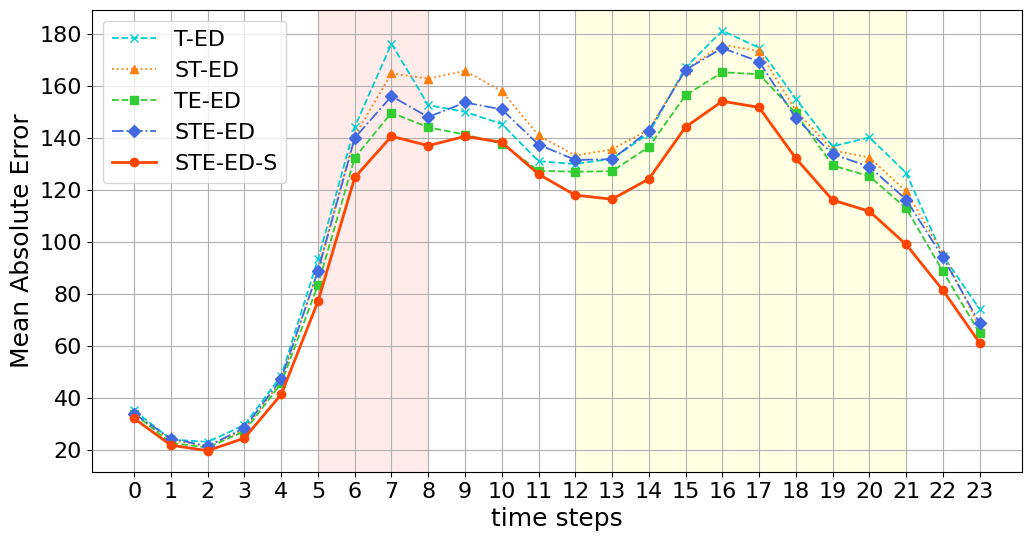

In [16]:
ticks = range(24)
labels = ticks

markers = ['x', '^', 's', 'D', 'o']
linestyles = ['--', ':', '--', '-.', '-']
linewidths = [1.3,1.3,1.3,1.3,2]
colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']
labels = ['T-ED', 'ST-ED', 'TE-ED', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for i, (name, result) in enumerate(dnn_result.items()):
    ax.plot(result['test_mae_steps'], marker=markers[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidths[i], label=labels[i])
    ax.axvspan(xmin=5, xmax=8, alpha=0.2, color='mistyrose')
    ax.axvspan(xmin=12, xmax=21, alpha=0.3, color='lightyellow')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('time steps', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.grid()
ax.legend(loc='upper left', fontsize=16)

# plt.savefig('../figs/mae_time_steps_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

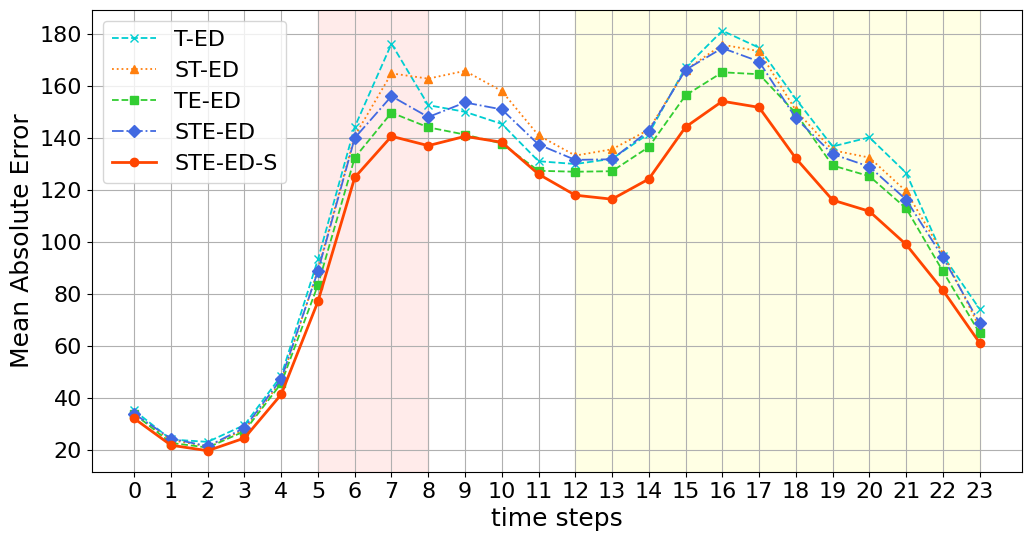

In [15]:
ticks = range(24)
labels = ticks

markers = ['x', '^', 's', 'D', 'o']
linestyles = ['--', ':', '--', '-.', '-']
linewidths = [1.3,1.3,1.3,1.3,2]
colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']
labels = ['T-ED', 'ST-ED', 'TE-ED', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for i, (name, result) in enumerate(dnn_result.items()):
    ax.plot(result['test_mae_steps'], marker=markers[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidths[i], label=labels[i])
    ax.axvspan(xmin=5, xmax=8, alpha=0.2, color='mistyrose')
    ax.axvspan(xmin=12, xmax=23, alpha=0.3, color='lightyellow')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('time steps', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.grid()
ax.legend(loc='upper left', fontsize=16)


# ax2 = ax.twinx()
# ax2.set_axisbelow(True)

mae_steps_ste_ed = dnn_result['STE-ED']['test_mae_steps']
mae_steps_ste_ed_s = dnn_result['STE-ED-S']['test_mae_steps']
impr_steps_ste = (mae_steps_ste_ed - mae_steps_ste_ed_s) / mae_steps_ste_ed

# ax.bar(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
# ax2.plot(impr_steps_ste*100, ':')
# ax2.bar(range(24), impr_steps_ste)
    
# ax.set_xticks(ticks=ticks)
# ax.tick_params(axis='x', labelsize=14)
# ax.set_xlabel('time steps', fontsize=16)
# ax2.set_ylabel('MAE Improvement Rate [%]', fontsize=16)
# ax.grid()
# ax2.legend(fontsize=16)

# plt.savefig('../figs/mae_time_steps_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

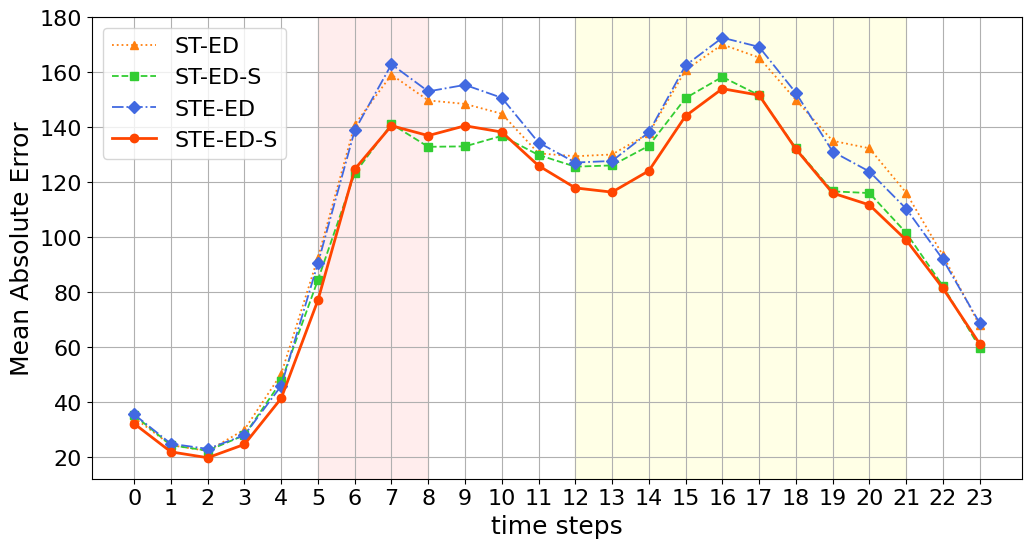

In [97]:
ticks = range(24)
labels = ticks

markers = ['^', 's', 'D', 'o']
linestyles = [':', '--', '-.', '-']
linewidths = [1.3, 1.3, 1.3, 2]
colors = ['tab:orange', 'limegreen', 'royalblue', 'orangered']
labels = ['ST-ED', 'ST-ED-S', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for i, (name, result) in enumerate(dnn_result.items()):
    ax.plot(result['test_mae_steps'], marker=markers[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidths[i], label=labels[i])
    ax.axvspan(xmin=5, xmax=8, alpha=0.2, color='mistyrose')
    ax.axvspan(xmin=12, xmax=21, alpha=0.3, color='lightyellow')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('time steps', fontsize=18)
ax.set_ylabel('Mean Absolute Error', fontsize=18)
ax.grid()
ax.legend(loc='upper left', fontsize=16)

# plt.savefig('../figs/mae_time_steps_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

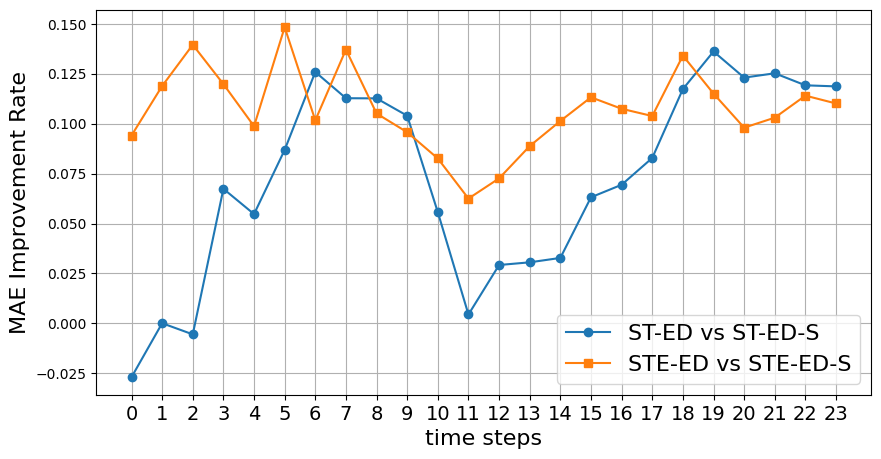

In [104]:
mae_steps_st_ed = dnn_result['ST-ED']['test_mae_steps']
mae_steps_st_ed_s = dnn_result['ST-ED-S']['test_mae_steps']
mae_steps_ste_ed = dnn_result['STE-ED']['test_mae_steps']
mae_steps_ste_ed_s = dnn_result['STE-ED-S']['test_mae_steps']

impr_steps_st = (mae_steps_st_ed - mae_steps_st_ed_s) / mae_steps_st_ed
impr_steps_ste = (mae_steps_ste_ed - mae_steps_ste_ed_s) / mae_steps_ste_ed

fig, ax = plt.subplots(figsize=(10,5))
ticks = range(24)
labels = ticks

ax.plot(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
ax.plot(impr_steps_ste, '-s', label='STE-ED vs STE-ED-S')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE Improvement Rate', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

plt.show()

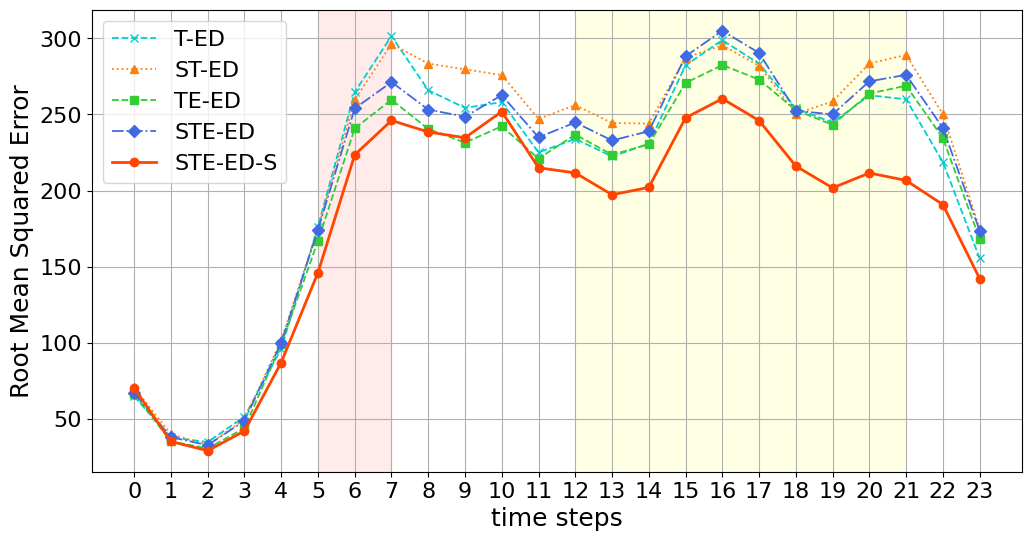

In [118]:
ticks = range(24)
labels = ticks

markers = ['x', '^', 's', 'D', 'o']
linestyles = ['--', ':', '--', '-.', '-']
linewidths = [1.3,1.3,1.3,1.3,2]
colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']
labels = ['T-ED', 'ST-ED', 'TE-ED', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for i, (name, result) in enumerate(dnn_result.items()):
    ax.plot(result['test_rmse_steps'], marker=markers[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidths[i], label=labels[i])
    ax.axvspan(xmin=5, xmax=7, alpha=0.2, color='mistyrose')
    ax.axvspan(xmin=12, xmax=21, alpha=0.3, color='lightyellow')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('time steps', fontsize=18)
ax.set_ylabel('Root Mean Squared Error', fontsize=18)
ax.grid()
ax.legend(loc='upper left', fontsize=16)

# plt.savefig('../figs/rmse_time_steps_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

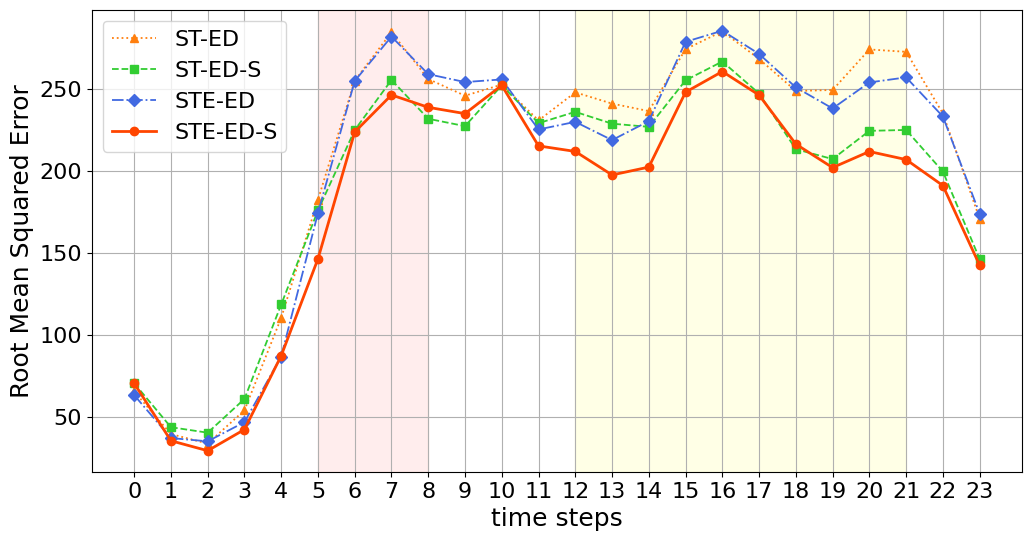

In [105]:
ticks = range(24)
labels = ticks

markers = ['^', 's', 'D', 'o']
linestyles = [':', '--', '-.', '-']
linewidths = [1.3, 1.3, 1.3, 2]
colors = ['tab:orange', 'limegreen', 'royalblue', 'orangered']
labels = ['ST-ED', 'ST-ED-S', 'STE-ED', 'STE-ED-S']

fig, ax = plt.subplots(figsize=(12,6))
for i, (name, result) in enumerate(dnn_result.items()):
    ax.plot(result['test_rmse_steps'], marker=markers[i], linestyle=linestyles[i], color=colors[i], linewidth=linewidths[i], label=labels[i])
    ax.axvspan(xmin=5, xmax=8, alpha=0.2, color='mistyrose')
    ax.axvspan(xmin=12, xmax=21, alpha=0.3, color='lightyellow')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('time steps', fontsize=18)
ax.set_ylabel('Root Mean Squared Error', fontsize=18)
ax.grid()
ax.legend(loc='upper left', fontsize=16)

# plt.savefig('../figs/rmse_time_steps_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

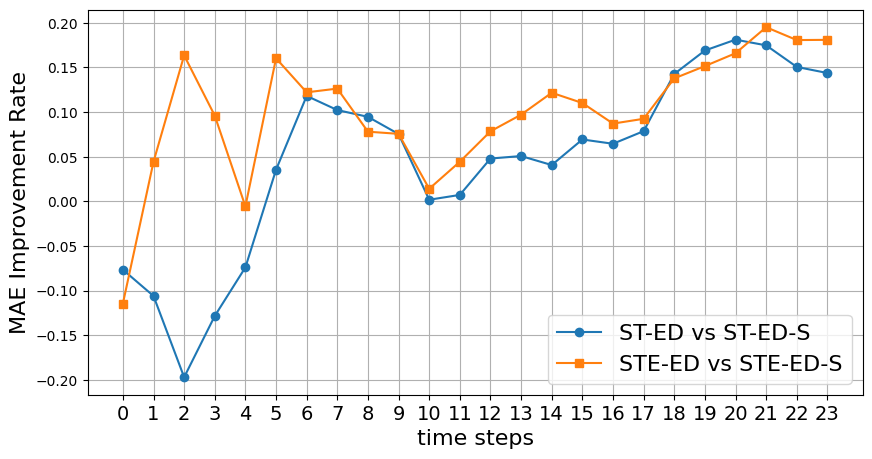

In [106]:
rmse_steps_st_ed = dnn_result['ST-ED']['test_rmse_steps']
rmse_steps_st_ed_s = dnn_result['ST-ED-S']['test_rmse_steps']
rmse_steps_ste_ed = dnn_result['STE-ED']['test_rmse_steps']
rmse_steps_ste_ed_s = dnn_result['STE-ED-S']['test_rmse_steps']

impr_steps_st = (rmse_steps_st_ed - rmse_steps_st_ed_s) / rmse_steps_st_ed
impr_steps_ste = (rmse_steps_ste_ed - rmse_steps_ste_ed_s) / rmse_steps_ste_ed

fig, ax = plt.subplots(figsize=(10,5))
ticks = range(24)
labels = ticks

ax.plot(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
ax.plot(impr_steps_ste, '-s', label='STE-ED vs STE-ED-S')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE Improvement Rate', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

plt.show()

### 平日と休日で比較

In [16]:
dt, rd, sr, un_sr, trf = dataset_valid[:][0]
print(dt.shape, rd.shape, sr.shape, trf.shape)

torch.Size([5355, 24]) torch.Size([5355, 1]) torch.Size([5355, 24, 5]) torch.Size([5355, 168, 5])


In [17]:
holiday_ids = dt_table.loc[pd.IndexSlice[:, :, 1]].values.flatten()

In [18]:
holiday_flags = torch.zeros_like(dt, dtype=torch.uint8)
for idx in holiday_ids:
    time_steps = (dt == idx)
    holiday_flags |= time_steps
holiday_flags = holiday_flags.all(dim=1)

holiday_time_steps = torch.where(holiday_flags == True)[0]
workday_time_steps = torch.where(holiday_flags == False)[0]

In [19]:
y_true = dataset_valid[:][-1][:,0]
y_true_holi = y_true[holiday_time_steps]
y_true_work = y_true[workday_time_steps]

In [79]:
performances = {
    name: {
        'mae': {},
        'rmse': {},
    }
    for name in dnn_result.keys()
}

for name, result in dnn_result.items():
    print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    mae, rmse = validate(y_pred, y_true)
    print(f'Whole:\t\tMAE={mae:.4f}, RMSE={rmse:.4f}')
    
    y_pred_holi = y_pred[holiday_time_steps]
    mae_holi, rmse_holi = validate(y_pred_holi, y_true_holi)
    performances[name]['mae']['holiday'] = mae_holi
    performances[name]['rmse']['holiday'] = rmse_holi
    print(f'Holidays:\tMAE={mae_holi:.4f}, RMSE={rmse_holi:.4f}')
    
    y_pred_work = y_pred[workday_time_steps]
    mae_work, rmse_work = validate(y_pred_work, y_true_work)
    performances[name]['mae']['workday'] = mae_work
    performances[name]['rmse']['workday'] = rmse_work
    print(f'Workdays:\tMAE={mae_work:.4f}, RMSE={rmse_work:.4f}')

-------------------- T-ED --------------------
Whole:		MAE=116.9480, RMSE=223.9303
Holidays:	MAE=159.9108, RMSE=283.0269
Workdays:	MAE=94.6995, RMSE=186.0915
-------------------- ST-ED --------------------
Whole:		MAE=116.7831, RMSE=234.8056
Holidays:	MAE=174.8675, RMSE=316.7997
Workdays:	MAE=86.7036, RMSE=178.0782
-------------------- TE-ED --------------------
Whole:		MAE=108.9069, RMSE=216.5745
Holidays:	MAE=153.2333, RMSE=279.5901
Workdays:	MAE=85.9522, RMSE=175.2516
-------------------- STE-ED --------------------
Whole:		MAE=113.9823, RMSE=226.8055
Holidays:	MAE=162.0187, RMSE=290.2604
Workdays:	MAE=89.1063, RMSE=185.6063
-------------------- STE-ED-S --------------------
Whole:		MAE=101.4352, RMSE=195.3598
Holidays:	MAE=142.4417, RMSE=257.4105
Workdays:	MAE=80.1997, RMSE=153.6764


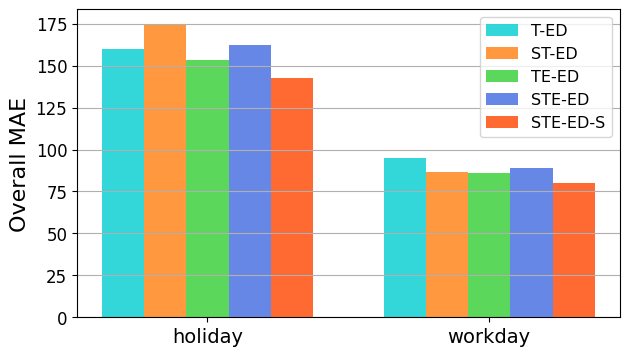

In [80]:
width = 0.15
x1 = [0, 1]
x2 = [x + width for x in x1]
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]
x5 = [x + width for x in x4]
xs_list = [x1, x2, x3, x4, x5]

colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']

fig, ax = plt.subplots(figsize=(7,4))
for i, (name, result) in enumerate(performances.items()):
    # print('-'*20, name, '-'*20)
    ax.bar(xs_list[i], result['mae'].values(), alpha=0.8, width=width, color=colors[i], label=name)
    
ax.set_xticks(ticks=[0.30, 1.30], labels=['holiday', 'workday'])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel('Overall MAE', fontsize=16)
ax.grid(axis='y')
ax.legend(fontsize=11.5)

plt.show()

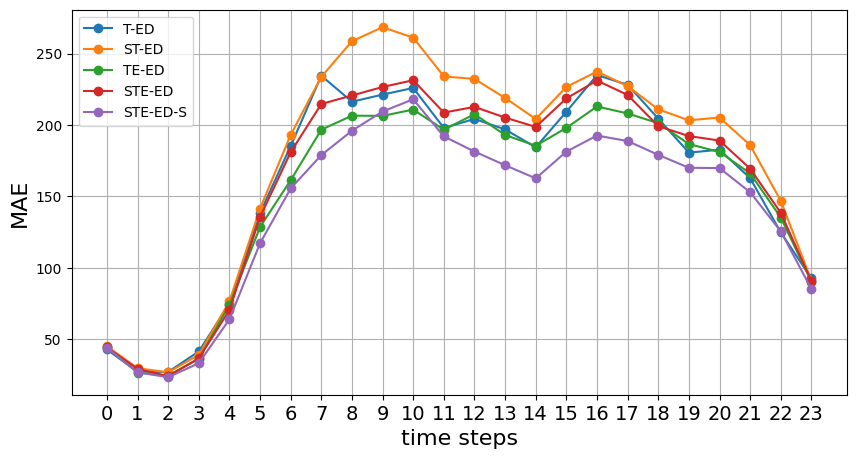

In [81]:
ticks = range(24)
labels = ticks

fig, ax = plt.subplots(figsize=(10,5))
for name, result in dnn_result.items():
    # print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    y_pred_holi = y_pred[holiday_time_steps]
    
    mae_steps = np.abs(y_pred_holi - y_true_holi).mean(axis=0)
    
    ax.plot(mae_steps, '-o', label=name)
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.grid()
ax.legend(fontsize=10)

plt.show()

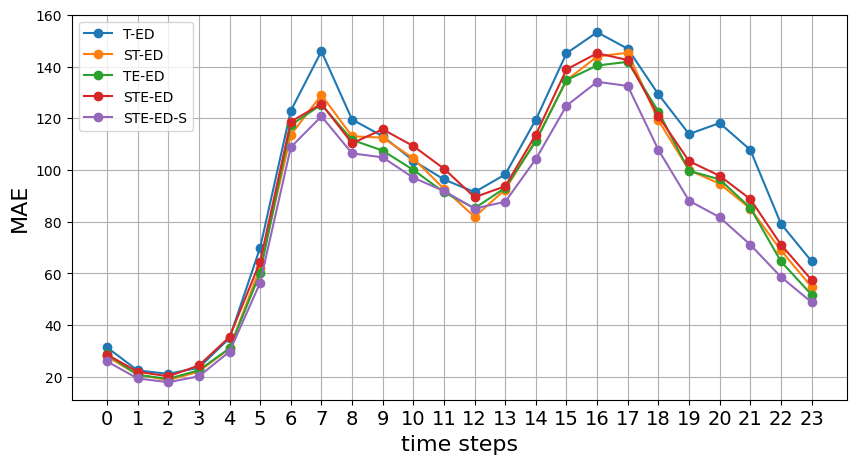

In [82]:
ticks = range(24)
labels = ticks

fig, ax = plt.subplots(figsize=(10,5))
for name, result in dnn_result.items():
    # print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    y_pred_work = y_pred[workday_time_steps]
    
    mae_steps = np.abs(y_pred_work - y_true_work).mean(axis=0)
    
    ax.plot(mae_steps, '-o', label=name)
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.grid()
ax.legend(fontsize=10)

plt.show()

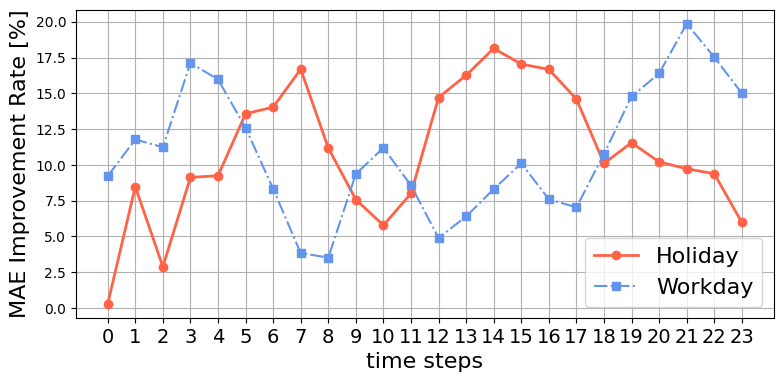

In [92]:
y_pred_ste_ed = dnn_result['STE-ED']['pred_test']
y_pred_ste_ed_holi = y_pred_ste_ed[holiday_time_steps]
y_pred_ste_ed_work = y_pred_ste_ed[workday_time_steps]

y_pred_ste_ed_s = dnn_result['STE-ED-S']['pred_test']
y_pred_ste_ed_s_holi = y_pred_ste_ed_s[holiday_time_steps]
y_pred_ste_ed_s_work = y_pred_ste_ed_s[workday_time_steps]

mae_steps_ste_ed_holi = torch.abs(y_pred_ste_ed_holi - y_true_holi).mean(dim=0)
mae_steps_ste_ed_s_holi = torch.abs(y_pred_ste_ed_s_holi - y_true_holi).mean(dim=0)

mae_steps_ste_ed_work = torch.abs(y_pred_ste_ed_work - y_true_work).mean(dim=0)
mae_steps_ste_ed_s_work = torch.abs(y_pred_ste_ed_s_work - y_true_work).mean(dim=0)

impr_steps_ste_holi = (mae_steps_ste_ed_holi - mae_steps_ste_ed_s_holi) / mae_steps_ste_ed_holi
impr_steps_ste_work = (mae_steps_ste_ed_work - mae_steps_ste_ed_s_work) / mae_steps_ste_ed_work

fig, ax = plt.subplots(figsize=(9,4))
ticks = range(24)
labels = ticks

# ax.plot(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
ax.plot(impr_steps_ste_holi * 100, '-o', color='tomato', lw=2, label='Holiday')
ax.plot(impr_steps_ste_work * 100, '-.s', color='cornflowerblue', label='Workday')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE Improvement Rate [%]', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

plt.show()

### ピーク時で比較

#### ピーク時をピンポイントで抽出

In [73]:
peak_indices = (y_true > y_true.quantile(0.8))

In [74]:
y_true = dataset_valid[:][-1][:,0]
y_true_peak = y_true[peak_indices]
y_true_off = y_true[~peak_indices]

In [75]:
for name, result in dnn_result.items():
    print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    mae, rmse = validate(y_pred, y_true)
    print(f'Whole:\t\tMAE={mae:.4f}, RMSE={rmse:.4f}')
    
    y_pred_peak = y_pred[peak_indices]
    mae_peak, rmse_peak = validate(y_pred_peak, y_true_peak)
    print(f'On-Peak:\tMAE={mae_peak:.4f}, RMSE={rmse_peak:.4f}')
    
    y_pred_off = y_pred[~peak_indices]
    mae_off, rmse_off = validate(y_pred_off, y_true_off)
    print(f'Off-Peak:\tMAE={mae_off:.4f}, RMSE={rmse_off:.4f}')

-------------------- ST-ED --------------------
Whole:		MAE=113.1847, RMSE=223.9827
On-Peak:	MAE=260.9103, RMSE=404.2744
Off-Peak:	MAE=76.2695, RMSE=147.8623
-------------------- ST-ED-S --------------------
Whole:		MAE=103.9189, RMSE=204.1369
On-Peak:	MAE=247.3245, RMSE=372.0446
Off-Peak:	MAE=68.0832, RMSE=132.2730
-------------------- STE-ED --------------------
Whole:		MAE=113.3227, RMSE=219.6795
On-Peak:	MAE=257.5452, RMSE=387.6953
Off-Peak:	MAE=77.2828, RMSE=150.8579
-------------------- STE-ED-S --------------------
Whole:		MAE=101.4352, RMSE=195.3598
On-Peak:	MAE=239.6436, RMSE=353.2422
Off-Peak:	MAE=66.8982, RMSE=128.5352


#### 全体的に混んでいる日をピックアップ

In [76]:
peak_indices = (y_true.mean(dim=1) > y_true.mean(dim=1).quantile(0.8))

In [77]:
y_true = dataset_valid[:][-1][:,0]
y_true_peak = y_true[peak_indices, :]
y_true_off = y_true[~peak_indices, :]

In [78]:
for name, result in dnn_result.items():
    print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    mae, rmse = validate(y_pred, y_true)
    print(f'Whole:\t\tMAE={mae:.4f}, RMSE={rmse:.4f}')
    
    y_pred_peak = y_pred[peak_indices]
    mae_peak, rmse_peak = validate(y_pred_peak, y_true_peak)
    print(f'On-Peak:\tMAE={mae_peak:.4f}, RMSE={rmse_peak:.4f}')
    
    y_pred_off = y_pred[~peak_indices]
    mae_off, rmse_off = validate(y_pred_off, y_true_off)
    print(f'Off-Peak:\tMAE={mae_off:.4f}, RMSE={rmse_off:.4f}')

-------------------- ST-ED --------------------
Whole:		MAE=113.1847, RMSE=223.9827
On-Peak:	MAE=195.5439, RMSE=342.1812
Off-Peak:	MAE=92.5949, RMSE=182.8615
-------------------- ST-ED-S --------------------
Whole:		MAE=103.9189, RMSE=204.1369
On-Peak:	MAE=188.2494, RMSE=318.3713
Off-Peak:	MAE=82.8363, RMSE=163.5536
-------------------- STE-ED --------------------
Whole:		MAE=113.3227, RMSE=219.6795
On-Peak:	MAE=190.0712, RMSE=323.3083
Off-Peak:	MAE=94.1356, RMSE=184.9102
-------------------- STE-ED-S --------------------
Whole:		MAE=101.4352, RMSE=195.3598
On-Peak:	MAE=176.9237, RMSE=292.5636
Off-Peak:	MAE=82.5631, RMSE=162.1989


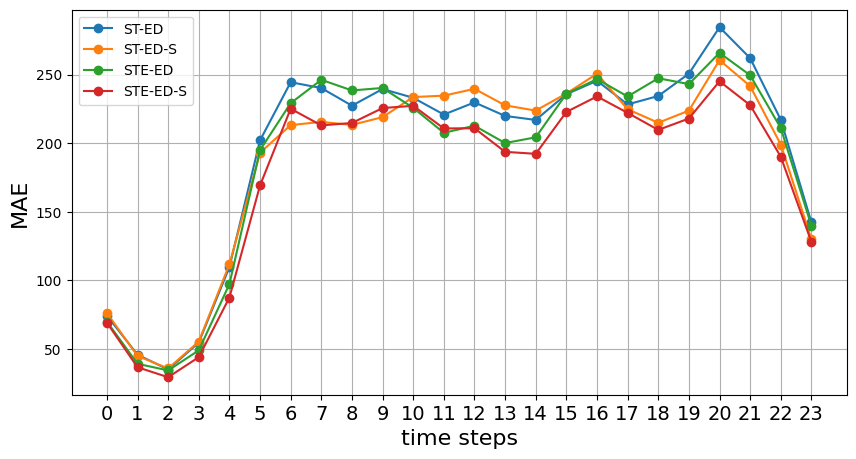

In [79]:
ticks = range(24)
labels = ticks

fig, ax = plt.subplots(figsize=(10,5))
for name, result in dnn_result.items():
    # print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    y_pred_peak = y_pred[peak_indices]
    
    mae_steps = np.abs(y_pred_peak - y_true_peak).mean(axis=0)
    
    ax.plot(mae_steps, '-o', label=name)
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.grid()
ax.legend(fontsize=10)

plt.show()

### 上りと下りで比較

In [67]:
dt, rd, sr, un_sr, trf = dataset_valid[:][0]
print(dt.shape, rd.shape, sr.shape, trf.shape)

torch.Size([5355, 24]) torch.Size([5355, 1]) torch.Size([5355, 24, 5]) torch.Size([5355, 168, 5])


In [68]:
inbound_flags = rd[:, 0] < 32

In [69]:
y_true = dataset_valid[:][-1][:,0]
y_true_inbound = y_true[inbound_flags]
y_true_outbound = y_true[~inbound_flags]

In [72]:
performances = {
    name: {
        'mae': {},
        'rmse': {},
    }
    for name in dnn_result.keys()
}

for name, result in dnn_result.items():
    print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    mae, rmse = validate(y_pred, y_true)
    print(f'Whole:\t\tMAE={mae:.4f}, RMSE={rmse:.4f}')
    
    y_pred_inbound = y_pred[inbound_flags]
    mae_inbound, rmse_inbound = validate(y_pred_inbound, y_true_inbound)
    performances[name]['mae']['inbound'] = mae_inbound
    performances[name]['rmse']['inbound'] = rmse_inbound
    print(f'Inbound:\tMAE={mae_inbound:.4f}, RMSE={rmse_inbound:.4f}')
    
    y_pred_outbound = y_pred[~inbound_flags]
    mae_outbound, rmse_outbound = validate(y_pred_outbound, y_true_outbound)
    performances[name]['mae']['outbound'] = mae_outbound
    performances[name]['rmse']['outbound'] = rmse_outbound
    print(f'Outbound:\tMAE={mae_outbound:.4f}, RMSE={rmse_outbound:.4f}')

-------------------- T-ED --------------------
Whole:		MAE=116.9480, RMSE=223.9303
Inbound:	MAE=114.6485, RMSE=221.8799
Outbound:	MAE=119.3217, RMSE=226.0273
-------------------- ST-ED --------------------
Whole:		MAE=116.7831, RMSE=234.8056
Inbound:	MAE=113.8790, RMSE=233.9831
Outbound:	MAE=119.7808, RMSE=235.6517
-------------------- TE-ED --------------------
Whole:		MAE=108.9069, RMSE=216.5745
Inbound:	MAE=110.5803, RMSE=223.2218
Outbound:	MAE=107.1795, RMSE=209.4917
-------------------- STE-ED --------------------
Whole:		MAE=113.9823, RMSE=226.8055
Inbound:	MAE=113.5133, RMSE=232.0817
Outbound:	MAE=114.4664, RMSE=221.2272
-------------------- STE-ED-S --------------------
Whole:		MAE=101.4352, RMSE=195.3598
Inbound:	MAE=101.5268, RMSE=200.1423
Outbound:	MAE=101.3406, RMSE=190.2971


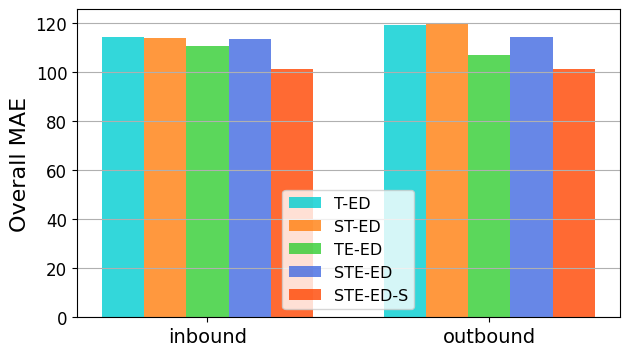

In [76]:
width = 0.15
x1 = [0, 1]
x2 = [x + width for x in x1]
x3 = [x + width for x in x2]
x4 = [x + width for x in x3]
x5 = [x + width for x in x4]
xs_list = [x1, x2, x3, x4, x5]

colors = ['darkturquoise', 'tab:orange', 'limegreen', 'royalblue', 'orangered']

fig, ax = plt.subplots(figsize=(7,4))
for i, (name, result) in enumerate(performances.items()):
    # print('-'*20, name, '-'*20)
    ax.bar(xs_list[i], result['mae'].values(), alpha=0.8, width=width, color=colors[i], label=name)
    
ax.set_xticks(ticks=[0.30, 1.30], labels=['inbound', 'outbound'])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylabel('Overall MAE', fontsize=16)
ax.grid(axis='y')
ax.legend(fontsize=11.5)

plt.show()

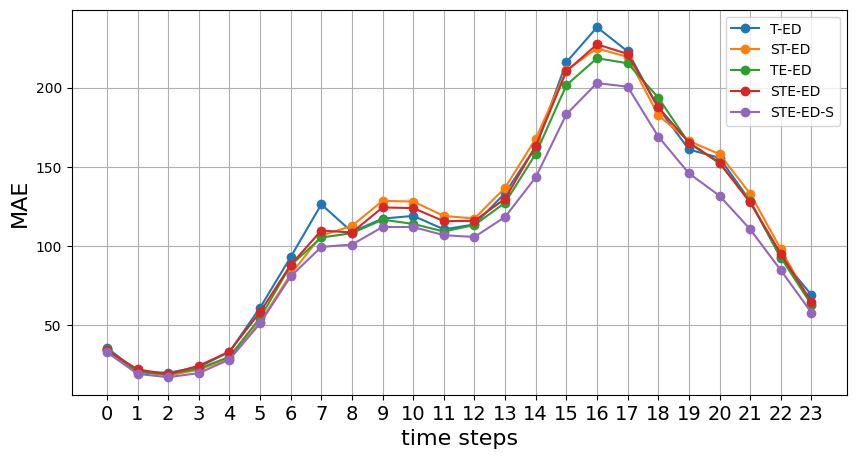

In [74]:
ticks = range(24)
labels = ticks

fig, ax = plt.subplots(figsize=(10,5))
for name, result in dnn_result.items():
    # print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    y_pred_inbound = y_pred[inbound_flags]
    
    mae_steps = np.abs(y_pred_inbound - y_true_inbound).mean(axis=0)
    
    ax.plot(mae_steps, '-o', label=name)
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.grid()
ax.legend(fontsize=10)

plt.show()

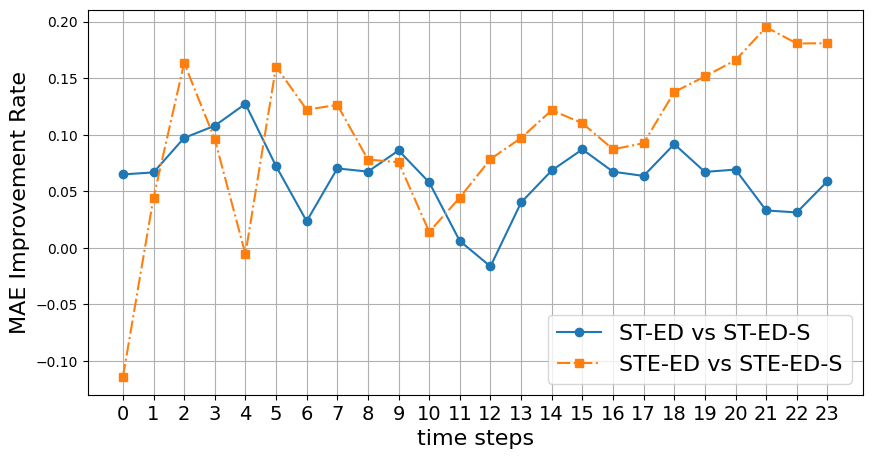

In [120]:
y_pred_st_ed = dnn_result['ST-ED']['pred_test']
y_pred_st_ed_inbound = y_pred_st_ed[inbound_flags]
y_pred_st_ed_s = dnn_result['ST-ED-S']['pred_test']
y_pred_st_ed_s_inbound = y_pred_st_ed_s[inbound_flags]
y_pred_ste_ed = dnn_result['STE-ED']['pred_test']
y_pred_ste_ed_inbound = y_pred_ste_ed[inbound_flags]
y_pred_ste_ed_s = dnn_result['STE-ED-S']['pred_test']
y_pred_ste_ed_s_inbound = y_pred_ste_ed_s[inbound_flags]

mae_steps_st_ed = torch.abs(y_pred_st_ed_inbound - y_true_inbound).mean(dim=0)
mae_steps_st_ed_s = torch.abs(y_pred_st_ed_s_inbound - y_true_inbound).mean(dim=0)
mae_steps_ste_ed = torch.abs(y_pred_ste_ed_inbound - y_true_inbound).mean(dim=0)
mae_steps_ste_ed_s = torch.abs(y_pred_ste_ed_s_inbound - y_true_inbound).mean(dim=0)

impr_steps_st = (mae_steps_st_ed - mae_steps_st_ed_s) / mae_steps_st_ed
impr_steps_st = (mae_steps_ste_ed - mae_steps_ste_ed_s) / mae_steps_ste_ed

fig, ax = plt.subplots(figsize=(10,5))
ticks = range(24)
labels = ticks

ax.plot(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
ax.plot(impr_steps_ste, '-.s', label='STE-ED vs STE-ED-S')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE Improvement Rate', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

plt.show()

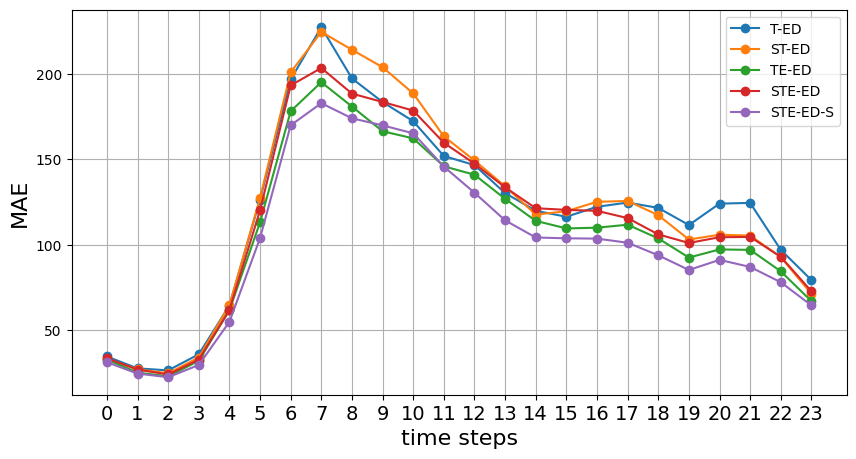

In [75]:
ticks = range(24)
labels = ticks

fig, ax = plt.subplots(figsize=(10,5))
for name, result in dnn_result.items():
    # print('-'*20, name, '-'*20)
    y_pred = result['pred_test']
    y_pred_outbound = y_pred[~inbound_flags]
    
    mae_steps = np.abs(y_pred_outbound - y_true_outbound).mean(axis=0)
    
    ax.plot(mae_steps, '-o', label=name)
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE', fontsize=16)
ax.grid()
ax.legend(fontsize=10)

plt.show()

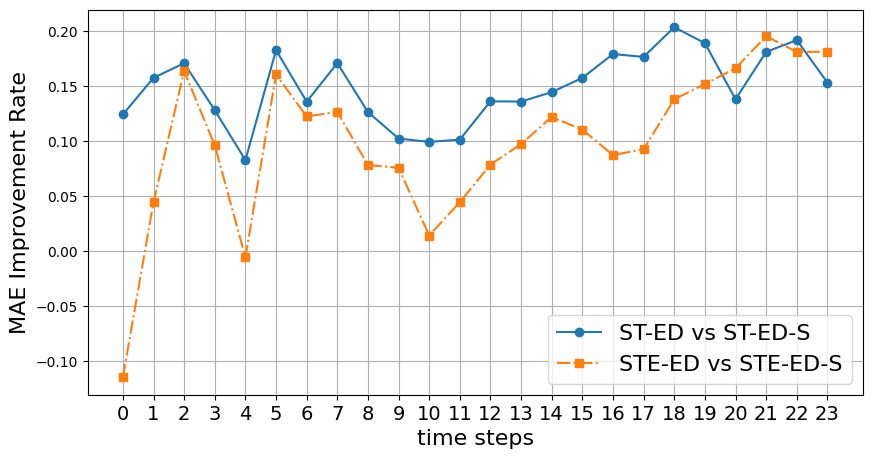

In [119]:
y_pred_st_ed = dnn_result['ST-ED']['pred_test']
y_pred_st_ed_outbound = y_pred_st_ed[~inbound_flags]
y_pred_st_ed_s = dnn_result['ST-ED-S']['pred_test']
y_pred_st_ed_s_outbound = y_pred_st_ed_s[~inbound_flags]
y_pred_ste_ed = dnn_result['STE-ED']['pred_test']
y_pred_ste_ed_outbound = y_pred_ste_ed[~inbound_flags]
y_pred_ste_ed_s = dnn_result['STE-ED-S']['pred_test']
y_pred_ste_ed_s_outbound = y_pred_ste_ed_s[~inbound_flags]

mae_steps_st_ed = torch.abs(y_pred_st_ed_outbound - y_true_outbound).mean(dim=0)
mae_steps_st_ed_s = torch.abs(y_pred_st_ed_s_outbound - y_true_outbound).mean(dim=0)
mae_steps_ste_ed = torch.abs(y_pred_ste_ed_outbound - y_true_outbound).mean(dim=0)
mae_steps_ste_ed_s = torch.abs(y_pred_ste_ed_s_outbound - y_true_outbound).mean(dim=0)

impr_steps_st = (mae_steps_st_ed - mae_steps_st_ed_s) / mae_steps_st_ed
impr_steps_st = (mae_steps_ste_ed - mae_steps_ste_ed_s) / mae_steps_ste_ed

fig, ax = plt.subplots(figsize=(10,5))
ticks = range(24)
labels = ticks

ax.plot(impr_steps_st, '-o', label='ST-ED vs ST-ED-S')
ax.plot(impr_steps_ste, '-.s', label='STE-ED vs STE-ED-S')
    
ax.set_xticks(ticks=ticks)
ax.tick_params(axis='x', labelsize=14)
ax.set_xlabel('time steps', fontsize=16)
ax.set_ylabel('MAE Improvement Rate', fontsize=16)
ax.grid()
ax.legend(fontsize=16)

plt.show()

### 実際の台数と予測結果を比較

In [41]:
def slice_days(pred_start_date, pred_days, sec_ids):
    def generate(y):
        zero_date = '2022/3/8'
        total_days = 84

        passed_days = (pd.Timestamp(pred_start_date) - pd.Timestamp(zero_date)).days

        y_list = []

        for sec_id in sec_ids:
            start = sec_id * total_days + passed_days
            end = start + pred_days

            y_list.append(y[start:end].flatten())

        return y_list
    
    return generate

#### 2022/5/3

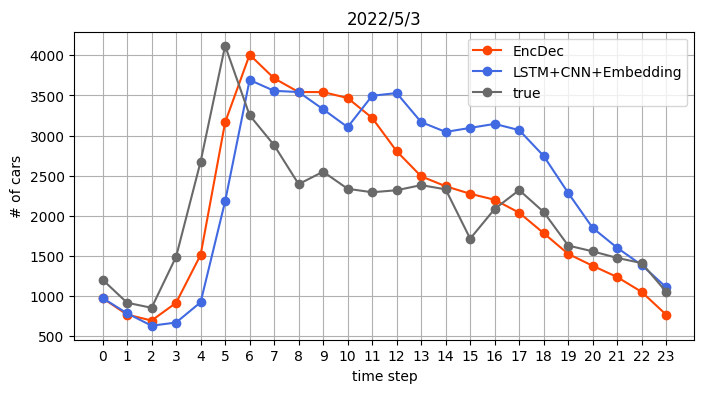

In [16]:
pred_start_date = '2022/5/3'
pred_days = 1
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(8,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='orangered')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='royalblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(len(y_true_list[0]))
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

#### 2022/5/14

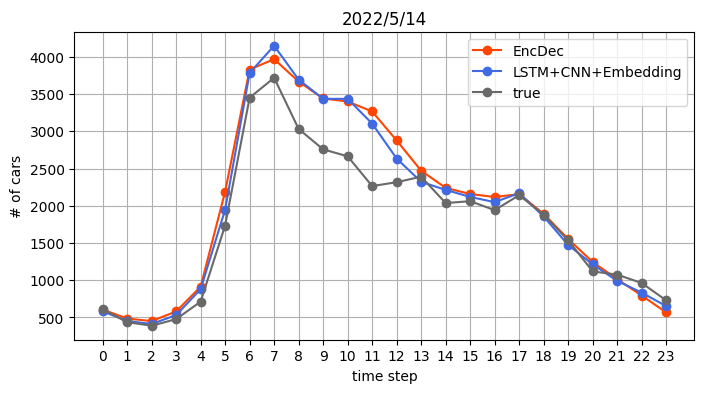

In [594]:
pred_start_date = '2022/5/14'
pred_days = 1
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(8,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='orangered')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='royalblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(len(y_true_list[0]))
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

#### 2022/5/11

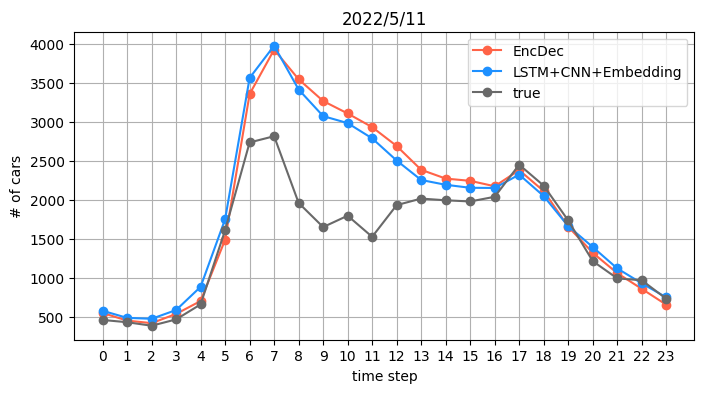

In [595]:
pred_start_date = '2022/5/11'
pred_days = 1
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(8,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='tomato')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='dodgerblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(len(y_true_list[0]))
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

#### GW

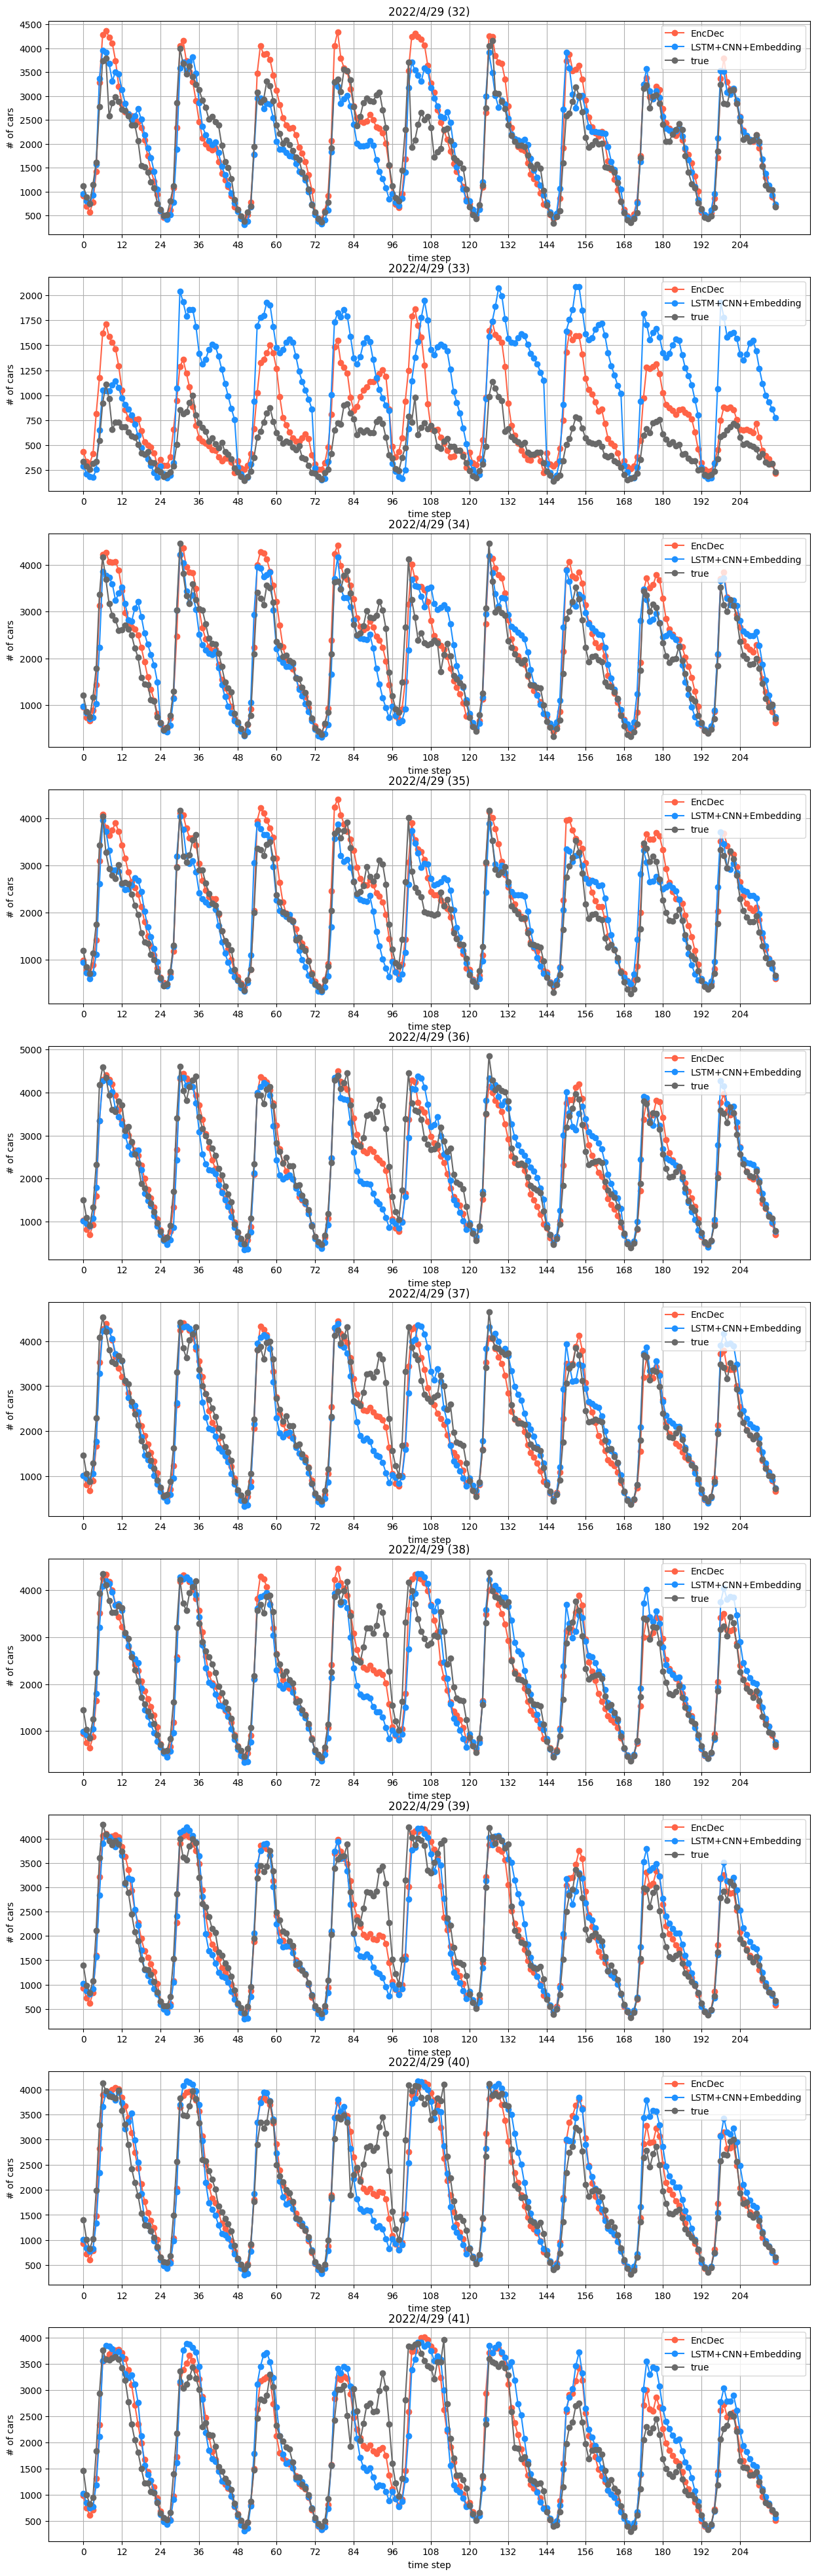

In [596]:
pred_start_date = '2022/4/29'
pred_days = 9
sec_ids = range(32, 42)

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])


fig, axes = plt.subplots(len(sec_ids),1, figsize=(15, 50))
for i, ax in enumerate(axes):
    ax.plot(y_encdec_list[i], '-o', label='EncDec', color='tomato')
    ax.plot(y_lce_list[i], '-o', label='LSTM+CNN+Embedding', color='dodgerblue')
    ax.plot(y_true_list[i], '-o', label='true', color='dimgray')

    ticks = range(0, len(y_true_list[0]), 12)
    ax.set_xticks(ticks=ticks)
    ax.set_xlabel('time step')
    ax.set_ylabel('# of cars')
    ax.set_title(f'{pred_start_date} ({sec_ids[i]})')
    ax.legend()
    ax.grid()
    
plt.show()

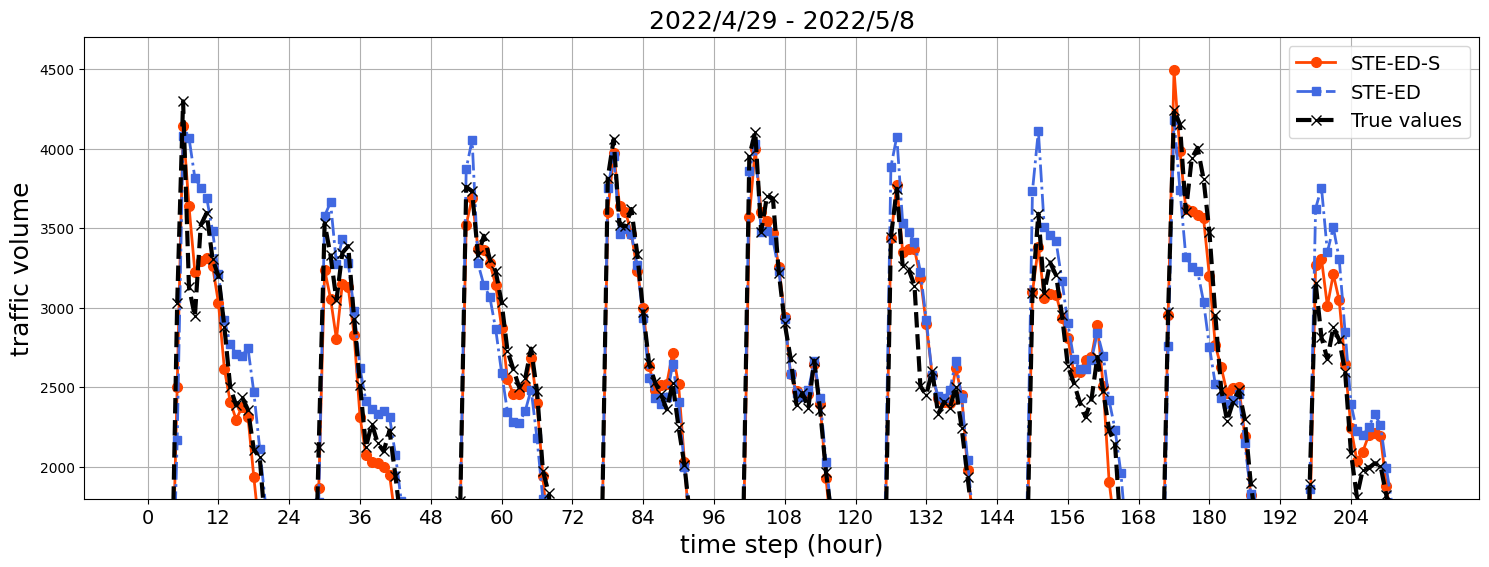

In [48]:
pred_start_date = '2022/4/29'
pred_days = 9
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_test)
y_ste_ed_s_list = gen(dnn_result['STE-ED-S']['pred_test'])
y_ste_ed_list = gen(dnn_result['STE-ED']['pred_test'])
y_st_ed_s_list = gen(dnn_result['ST-ED-S']['pred_test'])
y_st_ed_list = gen(dnn_result['ST-ED']['pred_test'])

fig, ax = plt.subplots(figsize=(18,6))

ax.plot(y_ste_ed_s_list[0], '-o', label='STE-ED-S', color='orangered', lw=2, markersize=7)
ax.plot(y_ste_ed_list[0], '-.s', label='STE-ED', color='royalblue', lw=2, markersize=6)
# ax.plot(y_st_ed_s_list[0], label='ST-ED-S', lw=2, markersize=6)
# ax.plot(y_st_ed_list[0], label='ST-ED', lw=2, markersize=6)
ax.plot(y_true_list[0], '--x', label='True values', color='black', lw=3, markersize=7)

ticks = range(0, len(y_true_list[0]), 12)
ax.tick_params(axis='x', labelsize=14)
ax.set_xticks(ticks=ticks)
ax.set_ylim(1800,)
ax.set_xlabel('time step (hour)', fontsize=18)
ax.set_ylabel('traffic volume', fontsize=18)
ax.set_title('2022/4/29 - 2022/5/8', fontsize=18)
ax.legend(fontsize=14)
ax.grid()

# plt.savefig('../figs/gw_predicted_rs1000.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

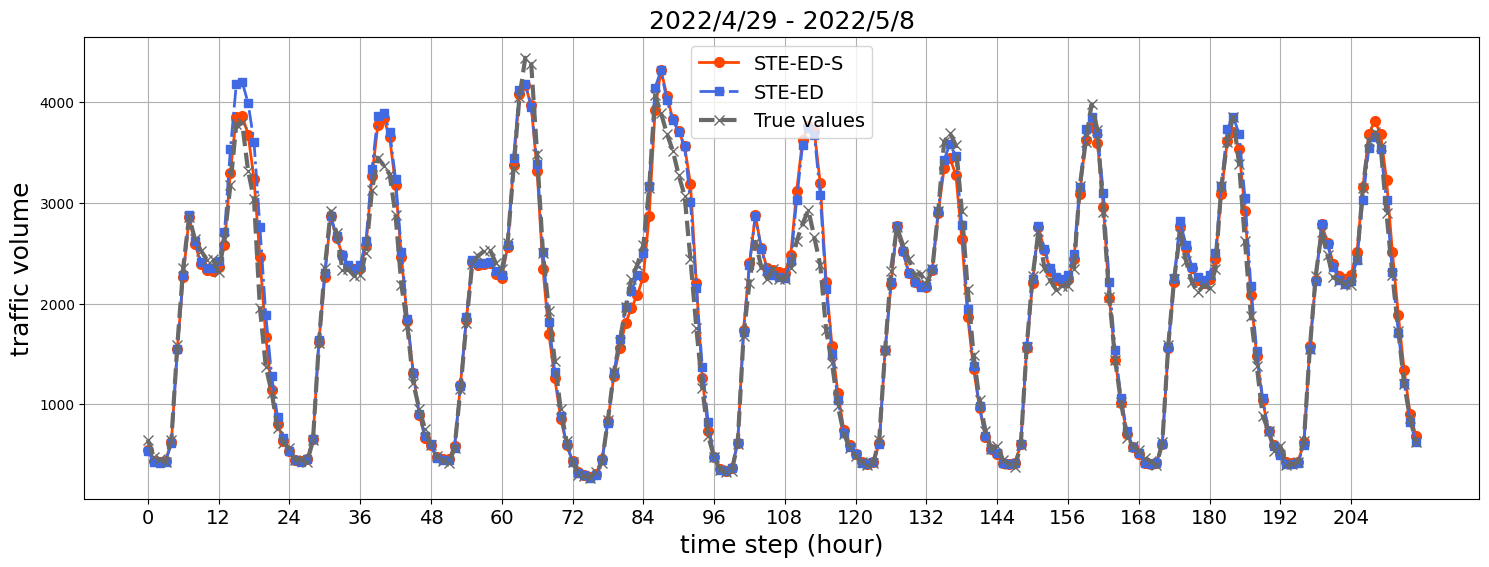

In [65]:
pred_start_date = '2022/4/29'
pred_days = 9
sec_ids = [24]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_test)
y_ste_ed_s_list = gen(dnn_result['STE-ED-S']['pred_test'])
y_ste_ed_list = gen(dnn_result['STE-ED']['pred_test'])

fig, ax = plt.subplots(figsize=(18,6))

ax.plot(y_ste_ed_s_list[0], '-o', label='STE-ED-S', color='orangered', lw=2, markersize=7)
ax.plot(y_ste_ed_list[0], '-.s', label='STE-ED', color='royalblue', lw=2, markersize=6)
ax.plot(y_true_list[0], '--x', label='True values', color='dimgray', lw=3, markersize=7)

ticks = range(0, len(y_true_list[0]), 12)
ax.tick_params(axis='x', labelsize=14)
ax.set_xticks(ticks=ticks)
ax.set_xlabel('time step (hour)', fontsize=18)
ax.set_ylabel('traffic volume', fontsize=18)
ax.set_title('2022/4/29 - 2022/5/8', fontsize=18)
ax.legend(fontsize=14)
ax.grid()

# plt.savefig('../figs/gw_predicted.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

### 普通の1週間 (月~日)

#### 3月

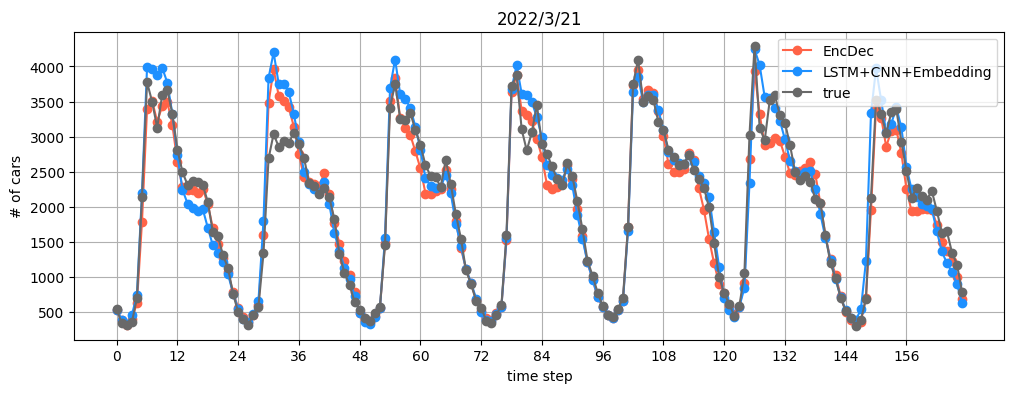

In [375]:
pred_start_date = '2022/3/21'
pred_days = 7
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(12,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='tomato')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='dodgerblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(0, len(y_true_list[0]), 12)
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

#### 4月

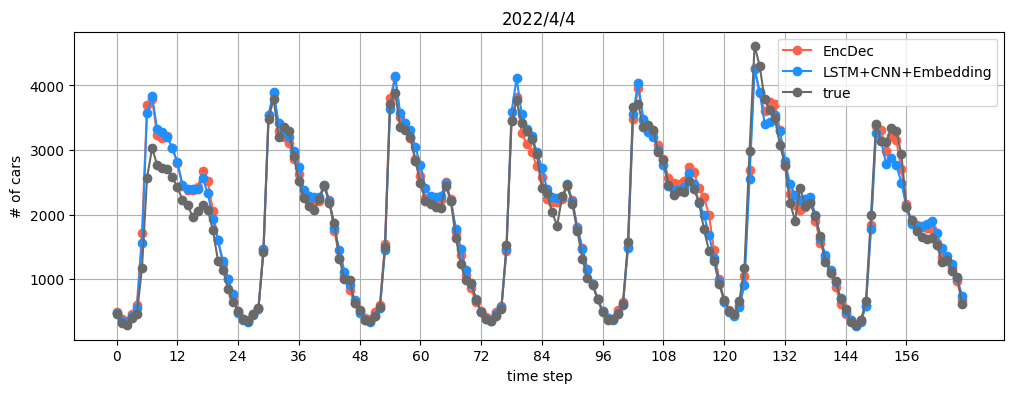

In [376]:
pred_start_date = '2022/4/4'
pred_days = 7
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(12,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='tomato')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='dodgerblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(0, len(y_true_list[0]), 12)
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

#### 5月

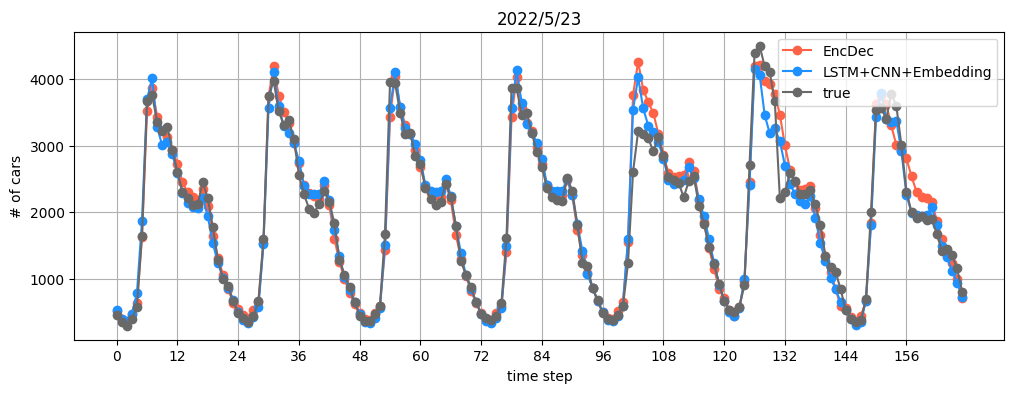

In [377]:
pred_start_date = '2022/5/23'
pred_days = 7
sec_ids = [34]

gen = slice_days(pred_start_date, pred_days, sec_ids)

y_true_list = gen(y_true)
y_encdec_list = gen(dnn_result['EncDec']['pred_test'])
y_lce_list = gen(dnn_result['LSTMCNNEmbedding']['pred_test'])

plt.figure(figsize=(12,4))
plt.plot(y_encdec_list[0], '-o', label='EncDec', color='tomato')
plt.plot(y_lce_list[0], '-o', label='LSTM+CNN+Embedding', color='dodgerblue')
plt.plot(y_true_list[0], '-o', label='true', color='dimgray')

ticks = range(0, len(y_true_list[0]), 12)
plt.xticks(ticks=ticks)
plt.xlabel('time step')
plt.ylabel('# of cars')
plt.title(pred_start_date)
plt.legend()
plt.grid()
plt.show()

## Baselines

In [29]:
with open("simple_ha_result.pkl", "rb") as f:
    simple_ha_result = pickle.load(f)
    
with open("ha_result.pkl", "rb") as f:
    ha_result = pickle.load(f)
    
with open("arima_result.pkl", "rb") as f:
    arima_result = pickle.load(f)
    
with open("svm_result.pkl", "rb") as f:
    svm_result = pickle.load(f)
    
with open("rf_result.pkl", "rb") as f:
    rf_result = pickle.load(f)

### HA

In [34]:
pred_test = simple_ha_result['pred_test']
mse_map = (pred_test - y_true.numpy())**2
rmse_steps = np.sqrt(mse_map.mean(axis=0))
    
for i in [1,3,6,12,18,24]:
    print(f'{i}h: RMSE={rmse_steps[i-1]:.3f}')
print(f'Overall: RMSE={rmse_steps.mean():.3f}')

1h: RMSE=820.035
3h: RMSE=948.810
6h: RMSE=558.651
12h: RMSE=567.047
18h: RMSE=802.024
24h: RMSE=719.844
Overall: RMSE=682.570


### Periodic HA

In [35]:
pred_test = ha_result['pred_test']
mse_map = (pred_test - y_true.numpy())**2
rmse_steps = np.sqrt(mse_map.mean(axis=0))
    
for i in [1,3,6,12,18,24]:
    print(f'{i}h: RMSE={rmse_steps[i-1]:.3f}')
print(f'Overall: RMSE={rmse_steps.mean():.3f}')

1h: RMSE=119.922
3h: RMSE=62.694
6h: RMSE=334.500
12h: RMSE=295.883
18h: RMSE=313.051
24h: RMSE=183.611
Overall: RMSE=269.771


### ARIMA

In [36]:
pred_test = arima_result['pred_test']
mse_map = (pred_test - y_true.numpy())**2
rmse_steps = np.sqrt(mse_map.mean(axis=0))
    
for i in [1,3,6,12,18,24]:
    print(f'{i}h: RMSE={rmse_steps[i-1]:.3f}')
print(f'Overall: RMSE={rmse_steps.mean():.3f}')

1h: RMSE=104.276
3h: RMSE=190.543
6h: RMSE=679.877
12h: RMSE=1384.908
18h: RMSE=1611.706
24h: RMSE=327.385
Overall: RMSE=996.760


### RF

In [38]:
pred_test = rf_result['pred_test']
mse_map = (pred_test - y_true.numpy())**2
rmse_steps = np.sqrt(mse_map.mean(axis=0))
    
for i in [1,3,6,12,18,24]:
    print(f'{i}h: RMSE={rmse_steps[i-1]:.3f}')
print(f'Overall: RMSE={rmse_steps.mean():.3f}')

1h: RMSE=77.208
3h: RMSE=563.985
6h: RMSE=649.464
12h: RMSE=1034.530
18h: RMSE=1227.108
24h: RMSE=436.366
Overall: RMSE=841.267


### SVM

In [39]:
pred_test = svm_result['pred_test']
mse_map = (pred_test - y_true.numpy())**2
rmse_steps = np.sqrt(mse_map.mean(axis=0))
    
for i in [1,3,6,12,18,24]:
    print(f'{i}h: RMSE={rmse_steps[i-1]:.3f}')
print(f'Overall: RMSE={rmse_steps.mean():.3f}')

1h: RMSE=128.141
3h: RMSE=206.457
6h: RMSE=740.157
12h: RMSE=1396.356
18h: RMSE=1587.909
24h: RMSE=315.537
Overall: RMSE=1004.792
